In [11]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
from writeit import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
fi = "/home/xin/pipes/indata/LeonExampleCheck/DividingFlowBottomDiff-2.0.inp"
fc = "/home/xin/pipes/indata/LeonExampleCheck/DividingFlowBottomDiff-2.0.config"
mtype  = 1 #this specifies Preissman slot model; 
n0 = PyNetwork(fi,fc,mtype) # an instance of the network class

   pipe | start node | end node
-----------------------------------
     0  |  1         | 2
     1  |  1         | 3
     2  |  4         | 0
     3  |  0         | 1


   node | #incoming pipes
-------------------------
  0     |  2
  1     |  3
  2     |  1
  3     |  1
  4     |  1


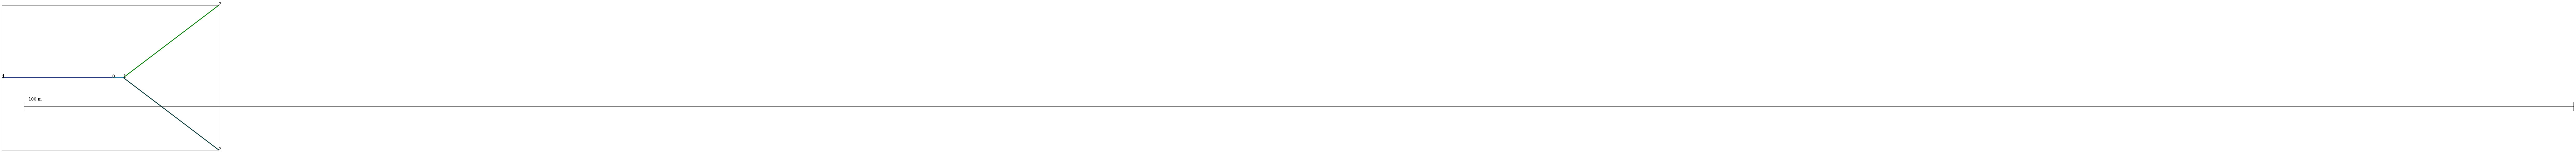

In [13]:
#showLayout() shows the connectivity--how the nodes and edges are connected 
n0.showLayout()
#you can also plot the network layout
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np = shape(conns)[0]
plotNetworkLayout(xs,ys,conns,ls,Np)

In [14]:
#look at specification for boundary value types for junction1s--these cannot be changed once network is instantiated
n0.showExternalBoundaries()

Junction1s are [2 3 4]
junction 2 has reflection boundary condition
junction 3 has reflection boundary condition
junction 4 has reflection boundary condition


Now let's check out the runtime parameters--these cannot be changed once network is instantiated

In [15]:
print "Simulation run time is %.2f s, number of time steps is %d, and pressure wavespeed is %.2f m/s"%(n0.T, n0.M, n0.a[0])

Simulation run time is 16.00 s, number of time steps is 80000, and pressure wavespeed is 100.00 m/s


Now we're going to modify initial conditions and run a simulation

In [16]:
p0 = PyPipe_ps(n0.Ns[0], n0.Ds[0], n0.Ls[0], n0.M, n0.a[0])
h0 = p0.AofH(0.4,False)
p1 = PyPipe_ps(n0.Ns[2], n0.Ds[2], n0.Ls[2], n0.M, n0.a[0])
h1 = p1.AofH(0.45,False)
n0.setIC(0, h0*np.ones(n0.Ns[0]),0.0*np.ones(n0.Ns[0]))  
n0.setIC(1, h0*np.ones(n0.Ns[1]),0.0*np.ones(n0.Ns[1]))
n0.setIC(2, h1*np.ones(n0.Ns[2]),0.0*np.ones(n0.Ns[2]))
n0.setIC(3, h1*np.ones(n0.Ns[3]),0.0*np.ones(n0.Ns[3]))

In [17]:
import time
V0 = n0.getTotalVolume()
dt = n0.T/float(n0.M)
dx = n0.Ls/[float(nn) for nn in n0.Ns]
t0 = time.clock()
n0.runForwardProblem(dt)
tf = time.clock()
Vf = n0.getTotalVolume()
print "Solve time is %.5f s"%(tf-t0)
print "Simulated time is %.5f s"%n0.T
print "change in volume is %e m^3"%(Vf-V0)
print n0

Solve time is 42.71968 s
Simulated time is 16.00000 s
change in volume is 1.975268e-09 m^3
Network at address 0x49faa40 with 5 nodes and 4 edges



In [18]:
print h0,h1

0.168393589724 0.227466702386


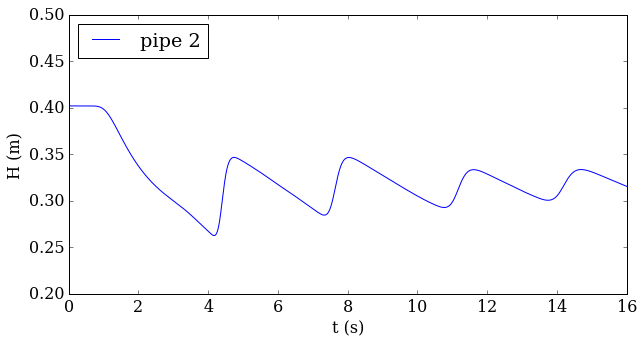

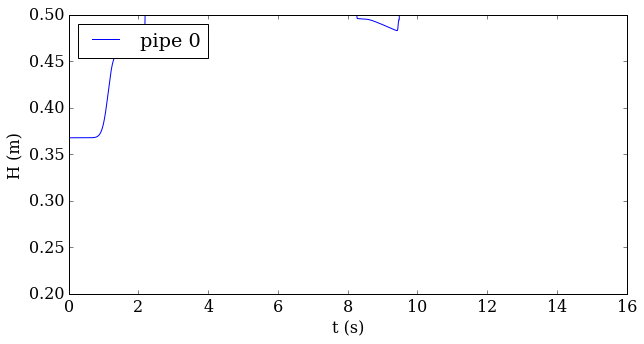

In [25]:
t = linspace(0,n0.T, n0.M+1)
for k in [2,0]:
    K = n0.Ns[k]/2
    Ht = n0.pressureTimeSeries(k,K) #this function returns H in cell K of pipe k, at each time step
    for i in xrange(len(Ht)):
        Ht[i]=p1.HofA(Ht[i],False)
    fig = plt.figure(figsize= (10,5))
    plot(t,Ht, label = 'pipe %d'%k)
    #plot(t,n0.Ds[k]*np.ones(len(t)),'k:')
    legend(loc = 'upper left')
    xlabel('t (s)')
    ylabel('H (m)')
    plt.ylim(0.2,0.5)

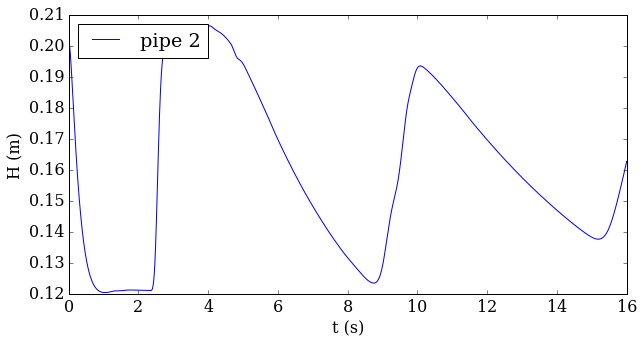

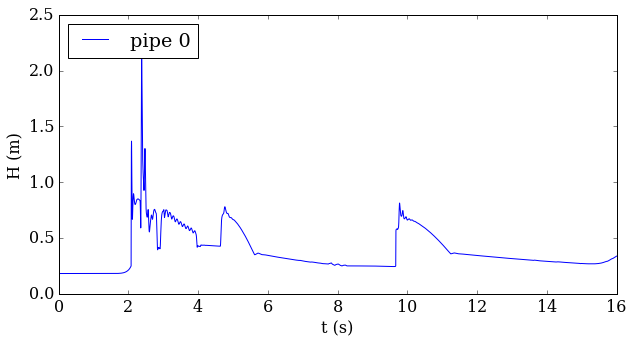

In [10]:
# check with ITM model
for k in [2,0]:
    K = n0.Ns[k]
    Ht = n0.pressureTimeSeries(k,K) #this function returns H in cell K of pipe k, at each time step
    fig = plt.figure(figsize= (10,5))
    plot(t,Ht, label = 'pipe %d'%k)
    #plot(t,n0.Ds[k]*np.ones(len(t)),'k:')
    legend(loc = 'upper left')
    xlabel('t (s)')
    ylabel('H (m)')

In [ ]:
from __future__ import division
import sys
sys.path.append("..")    
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline
%pylab notebook
from writeit import *
import pickle
import time

#*********************************************************************************
pipe_interest=[0,1,2]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=400               # unit: s
#*********************************************************************************

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(0,n0.Ls[j]-1,n0.Ns[j])
    x_interest.append(x)

#create initial figure
from matplotlib import animation
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1, 5)
lines = [plt.plot([], [],label='pipe {}'.format(pipe_interest[i]))[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)

def animate(index): 
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n0.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        line.set_data(x_interest[i],Hx)
        plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
        #line.set_label('pipe %d t=%.2f s'%(j,(dt*(M_start+index*Mi_draw))))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=100, blit=True)
plt.legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
print x_interest[1]
print len(x_interest[1])
print n0.pressureSpaceSeries(1,60000)
print len(n0.pressureSpaceSeries(1,60000))
qh = n0.qhist(1)
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)
N = n0.Ns[1]
print qh[idx_t(0,int(N),60000,N)]
"""

N = n1.Ns[j]
qh = n1.qhist(j) 
Ak=qh[idx_t(0,k,m,N)] "m is time step,k is grid number"
AN=qh[idx_t(1,N,1,N)]
"""

In [ ]:
#*********************************************************************************
pipe_interest=[0,1,3]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=400               # unit: s
#*********************************************************************************

# animation already imported above
plt.ion()
plt.show()

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length+1,pipe_length+n0.Ls[j]-1,n0.Ns[j]-1)
    x_interest.append(x)
    pipe_length=pipe_length+n0.Ls[j]
x_interest_combine = np.concatenate(x_interest,axis =0)

#create initial figure
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1, 5)
lines = [plt.plot([], [])[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)
H_interest=[]

def animate(index):
    H_interest_tfixed = []
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n0.pressureSpaceSeries(j,M_start+index*Mi_draw)[1:]
        #this returns H as a function of x in pipe j at time step m
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    H_interest_combine = np.concatenate(H_interest[index],axis =0)
    line.set_data(x_interest_combine,H_interest_combine)
    plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=10, blit=True)
plt.show()
#anim.save('/home/xin/pipes/examples/output_data/T_junction_detection/Taddconti-pipe %s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))


#anim = animation.FuncAnimation(fig, animate, init_func=init,frames=3, interval=20, blit=True)
#anim.save("basic_animation.mp4")
#plt.show()
    # time.sleep(0.01)
    # bbox_to_anchor: the bbox that the legend will be anchored, 1.05 means 1.05 times of figure length
    # borderaxespad: the pad between the axes and legend border
    # optional:legend(loc = 'upper left')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()


<p>**IMPORTANT:** once you instantiate a network, you can only run the method *runForwardProblem(dt)* **ONCE** 
           because only enough memory is allocated to store a single run of M time steps. If you want to re-run a simulation, you need to either </p>
<ol>
 <li> re-instantiate the network using n0 = PyNetwork(fi,fc,mtype) to create a new network and start at time T=0, OR</li>
 <li> first run n0.reset(), which will allow you to run the simulation another T seconds starting with the last state at t=T
     see how to use this in *Intro_simulation_Alameda.ipynb*</li>
     
<p> For now we're just going to look at the data from this run using several attributes of the PyNetwork class.</p>

In [ ]:
#The PyNetwork function q(k) returns a list [A,Q] of the current data in pipe k
#Below we use this to retrieve and plot the final cross sectional area
# along length of each pipe and compare with our initial conditions
fig, ax1=  plt.subplots(figsize=(15,10), nrows = n0.Nedges)
fig, ax2=  plt.subplots(figsize=(15,10), nrows = n0.Nedges)
for k in range(n0.Nedges):
    N =n0.Ns[k] # Length of each pipe in integer upper
    x = linspace(0,n0.Ls[k], N)# n0.Ls>>>>real length, genarate N number bet 0 and total length
    q = n0.q(k)#this is the current data (A,Q)
    A = q[0:N]#first N entries are values of A in each cell)
    Q = q[N:]#next N entries are values of Q in each cell
    

    ax1[k].plot(x,A0[k],'g',label='pipe %d initial'%k)#we stored this above
    ax1[k].plot(x,A,'k',label='pipe %d final'%k)
    ax1[k].legend()
    ax1[k].set_ylabel('A(x)')
    ax1[k].set_xlabel('x')
  
    ax2[k].plot(x,Q0[k],'g',label='pipe %d initial'%k)#we stored this above
    ax2[k].plot(x,Q,'k',label='pipe %d final'%k)
    ax2[k].set_ylabel('Q(x)')
    ax2[k].set_xlabel('x')
    ax2[k].legend()
#print A0


<p>The vector of the entire history of (A,Q) at each time step is stored 
      and can be accessed using the PyNetwork function q_hist(i)</p>
<p>However, this requires some slightly complicated indexing (see water_hammer.ipynb for an example)</p>
<p>Below we use two shortcut functions to look at pressure head $H = \bar{p}/(\rho g)$ as a function of space and time in each pipe.</p>

In [ ]:
#first look at a time series of pressure data near the end of each pipe
t = linspace(0,n0.T, n0.M+1)
for k in range(n0.Nedges):
    K = n0.Ns[k]-2 #index of cell we want to look at
    Ht = n0.pressureTimeSeries(k,K)#this function returns H in cell K of pipe k, at each time step
    plot(t,Ht, label = 'pipe %d'%k)
    plot(t,n0.Ds[k]*np.ones(len(t)),'k:')
legend(loc = 'upper left')
xlabel('t (s)')
ylabel('H (m)')
print 'dashed line denotes pipe crown'

In [ ]:
#now look at pressure head H as a function of x in pipe 2 at time step m, for m = 0,100, ...M
# import a nice colormap to do this
from matplotlib import cm
import matplotlib.colors as colors
cNorm  = colors.Normalize(vmin=0, vmax=n0.M)
sMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('Blues') )
figure(figsize(10,6))
for m in range(0,n0.M,100):
    Hx = n0.pressureSpaceSeries(2,m)#this returns H as a function of x in pipe 2 at time step m
    x = np.linspace(0,n0.Ls[2],n0.Ns[2])
    plot(x,Hx, lw = 2, color = sMap.to_rgba(m), label = 't=%.2f'%(dt*m))
xlabel('x (m)')
ylabel('H (m) in pipe 2')
xlim(0,n0.Ls[2])
legend(loc = 'upper left')

Ok, we've now seen how to instantiate a network class, look at some attributes, run a simulation, and extract the data. However, it is possible (likely!) that you will want to change runtime parameters like the simulation time, the boundary condition type, the boundary values, and more. Below we will use *writeit.py* to create new .inp and .config files with desired parameters. Then we can instantiate another network and run it!

In [ ]:
Np = n0.Nedges #number of pipes
T = 20 #run time in seconds
a = 150 #pressure wave speed in m/s (this sets the Preissman slot width)

#pipe stuff
Ls = [100,50,25] #try new pipe lengths
Ns = [int(l) for l in Ls]   # set dx = 1 meter by assigning 1 grid cell per meter of length
Ds = [0.1,0.05,0.05]  #try new pipe diameters
Mrs = n0.Mrs  #keep Manning coeff the same
h0s = [5,5,5] #constant initial value of water height (if you want nonconstant, specify later with setIC)
q0s = [0.007, 0.007,0.007] #constant initial discharge Q (if you want nonconstant, specify later with setIC)

#runtime stuff
dx = [Ls[i]/Ns[i] for i in range(Np)]  
M = int(T*a/(max(dx)*.8))#set time steps based on dx to assure CFL condition (may need to adjust up if slopes are steep)

#junction stuff
elevs = [0,0,0,0] #make it flat this time
jt = n0.nodeTypes #junction type (can also write this out as a list--in this case, [1,3,1,1]
# note that below, r, bt, and bval only matter for the nodes with one incoming pipe--nodes 0,1 and 2
r  = [0,0,1,0] #reflection: we're doing specified bounary at nodes 0 and 3, reflection at node 2
bt = [1,0,0,2] #boundary type (only matters if r=0). Here we're specifying Q at node 0 and orifice outflow at node 2
bv = [0.007,0,0,n0.Ds[2]/2] #node 0: Q = 0.007; node 3: orifice opening height =D/2



In [ ]:
#specify .inp file with network connectivity
oldinp = "../indata/mynetwork2.0.inp"
#new prefix for .inp and .config files that will be used for actual runtime parameters
fn = "../indata/myfile_new"
#and write the files!
(fi2, fc2) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)

In [ ]:
print "name of new files is %s and %s "%(fi2, fc2)

In [ ]:
# now make a new network
n1 = PyNetwork(fi2,fc2,mtype)

In [ ]:
n1.showExternalBoundaries()
T = n1.T
M = n1.M
dt = T/float(M)

In [ ]:

V0 = n1.getTotalVolume()
t0 = time.clock()
n1.runForwardProblem(dt)
tf = time.clock()
Vf = n1.getTotalVolume()
print "Solve time is %.5f s"%(tf-t0)
print "Simulated time is %.5f s"%n0.T
print "change in volume is %e m^3"%(Vf-V0)
print "note we don't expect volume to be constant since we have orifice and outflow boundaries"

In [ ]:
t = linspace(0,n1.T, n1.M+1)
for k in range(0,n1.Nedges):
    K = n1.Ns[k]/2 #index of cell we want to look at (midway in each pipe)
    Ht = n1.pressureTimeSeries(k,K)#this function returns H in cell K of pipe k, at each time step
    plot(t,Ht, label = 'pipe %d'%k)
    plot(t,n1.Ds[k]*np.ones(len(t)),'k:')
legend(loc = 'lower right')
xlabel('t (s)')
ylabel('H (m)')
print 'dashed line denotes pipe crown'

Parting thoughts: what to try if your simulation isn't working (a partial list)
<ul>
<li>Try using a smaller time step</li>
<li> Check your .inp and .config files to make sure that your network connectivity and parameters are what you think they are</li>
<li>Check that your initial and boundary conditions are what they think they are</li>
<li> Watch out for totally empty pipes! I usually use $\epsilon A_f$ where $\epsilon$ is 0.01 or 0.001, as an initial condition in an 'empty' pipe. This avoids tricky things happening with near-zero cross sectional areas.</li>
<li>Watch out for $A$ specified on boundary--this can be finicky if you have a big jump from the boundary value to the interior value of the pipe. Try introducing a transition pipe with the same value of $A$ throughout that connects to the first pipe in your network </li>
<li>Try doing a shorter or smaller simulation</li>
<li>Check that you haven't accidentally zeroed something out through Python integer division. Remember! 2/5 = 0, but 2./5. = 0.4</li>
<li> ...and many other things! </li>
</ul>